- 여기서부터 그냥 공장처럼 피쳐 뽑아낼 각을 재기 시작함
- 범주는 숫자와 비율
- 수치는 평균

In [1]:
from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
data_path = "../take-home-interview/"

In [3]:
app = pd.read_csv(data_path + "loan_application.csv")
app_prev = pd.read_csv(data_path + "application_previous.csv")

### 칼럼별 전처리

In [4]:
int_cols = app_prev.dtypes[app_prev.dtypes == int].index.tolist()
float_cols = app_prev.dtypes[app_prev.dtypes == float].index.tolist()
cate_cols = app_prev.dtypes[app_prev.dtypes == 'object'].index.tolist()

## 칼럼 예외 처리
int_cols = [col for col in int_cols if 'id' not in col]

In [5]:
## numeric -> 평균
res = []
for col in int_cols + float_cols:
    res.append(app_prev.groupby("application_id_current")[col].mean())

numeric_mean_features = pd.concat(res, axis=1)

In [7]:
## cate -> 카운트해서 pivot
res = []
for col in tqdm(cate_cols):
    count_df = app_prev.groupby(["application_id_current", col]).size().reset_index(name=f"{col}_count")
    count_pivot = count_df.pivot(index="application_id_current", columns=col, values=f"{col}_count").fillna(0)

    assert count_pivot.max().max() < 32767
    count_pivot = count_pivot.astype(np.int16)
    
    count_pivot.columns = col + "_" + count_pivot.columns
    res.append(count_pivot)
    
cate_count_features = pd.concat(res, axis=1)

100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


In [10]:
app_prev_features = pd.concat([numeric_mean_features, cate_count_features], axis=1)

In [11]:
app_prev_features

,hour_appr_process_start,nflag_last_appl_in_day,days_decision,sellerplace_area,amt_annuity,amt_application,amt_credit,amt_down_payment,amt_goods_price,rate_down_payment,...,name_seller_industry_Industry,name_seller_industry_Jewelry,name_seller_industry_MLM partners,name_seller_industry_Tourism,name_seller_industry_XNA,name_yield_group_XNA,name_yield_group_high,name_yield_group_low_action,name_yield_group_low_normal,name_yield_group_middle
application_id_current,,,,,,,,,,,,,,,,,,,,,
100001,13.000000,1.0,-1740.000,23.000,3951.000000,24835.500,23787.00,2520.00,24835.500,0.104326,...,0,0,0,0,0,0,1,0,0,0
100002,9.000000,1.0,-606.000,500.000,9251.775000,179055.000,179055.00,0.00,179055.000,0.000000,...,0,0,0,0,0,0,0,0,1,0
100003,14.666667,1.0,-1305.000,533.000,56553.990000,435436.500,484191.00,3442.50,435436.500,0.050030,...,0,0,0,0,1,0,0,0,1,2
100004,5.000000,1.0,-815.000,30.000,5357.250000,24282.000,20106.00,4860.00,24282.000,0.212008,...,0,0,0,0,0,0,0,0,0,1
100005,10.500000,1.0,-536.000,18.000,4813.200000,22308.750,20076.75,4464.00,44617.500,0.108964,...,0,0,0,0,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251,17.000000,1.0,-273.000,30.000,6605.910000,40455.000,40455.00,0.00,40455.000,0.000000,...,0,0,0,0,0,0,1,0,0,0
456252,10.000000,1.0,-2497.000,190.000,10074.465000,57595.500,56821.50,3456.00,57595.500,0.062443,...,0,0,0,0,0,0,0,0,1,0
456253,11.500000,1.0,-2380.000,22.000,4770.405000,24162.750,20625.75,4403.25,24162.750,0.214316,...,0,0,0,0,0,0,2,0,0,0


### Merge

In [12]:
df = app.loc[app['type'] == 'train', ['application_id_current', 'target']].reset_index(drop=True)
df = df.merge(app_prev_features, on="application_id_current", how='left')

In [13]:
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['application_id_current', 'target'], axis=1), df['target'], test_size=0.2
)

### Evaluate

In [15]:
import evaluate_with_lightgbm

auc_dic = {}

/Users/dane.ahn/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/dane.ahn/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Info] Number of positive: 15764, number of negative: 181042
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5886
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 136
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080099 -> initscore=-2.441000
[LightGBM] [Info] Start training from score -2.441000
Training until validation scores don't improve for 100 rounds
[20]	valid_0's auc: 0.650252
[40

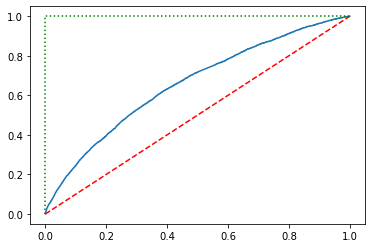

AUC on train: 0.7041
AUC on test: 0.6566
f1_score on train: 0.2305
f1_score on test: 0.2097


In [16]:
auc_dic['app_prev_only'] = evaluate_with_lightgbm.run(X_train, X_test, y_train, y_test)

### Together

In [17]:
df = app.loc[app['type'] == 'train'].drop("type", axis=1).reset_index(drop=True)
df = df.merge(app_prev_features, on="application_id_current", how='left')

df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['application_id_current', 'target'], axis=1), df['target'], test_size=0.2
)

/Users/dane.ahn/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/dane.ahn/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Info] Number of positive: 15908, number of negative: 180898
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17135
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 251
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080831 -> initscore=-2.431111
[LightGBM] [Info] Start training from score -2.431111
Training until validation scores don't improve for 100 rounds
[20]	valid_0's auc: 0.742571
[4

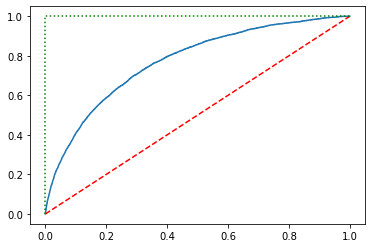

AUC on train: 0.8087
AUC on test: 0.7723
f1_score on train: 0.3059
f1_score on test: 0.2797


In [18]:
auc_dic['appXapp_prev'] = evaluate_with_lightgbm.run(X_train, X_test, y_train, y_test)

/Users/dane.ahn/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/dane.ahn/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Info] Number of positive: 15988, number of negative: 180818
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17163
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 251
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081237 -> initscore=-2.425653
[LightGBM] [Info] Start training from score -2.425653
Training until validation scores don't improve for 100 rounds
[20]	valid_0's auc: 0.746271
[4

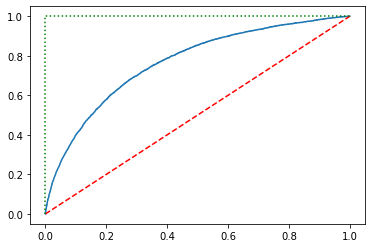

AUC on train: 0.8250
AUC on test: 0.7659
f1_score on train: 0.3201
f1_score on test: 0.2812


In [19]:
auc_dic['appXapp_prev_feature_selected'] = evaluate_with_lightgbm.run(X_train, X_test, y_train, y_test, X_train.shape[1] // 5)

### Final result

In [20]:
pd.Series(auc_dic).sort_values().reset_index()

,index,0
0,app_prev_only,0.656598
1,appXapp_prev_feature_selected,0.765892
2,appXapp_prev,0.772289
